### Importing libraries and variable definitions

In [46]:
### Import libraries
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    make_scorer,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_curve,
    average_precision_score,
)
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import joblib

In [47]:
# Display all columns and rows
pd.options.display.max_columns = None
pd.options.display.max_rows = None
# Disable scientific notation
pd.options.display.float_format = '{:.2f}'.format

In [48]:
# Load the data
data = pd.read_pickle("../data/BRFSS2022_modeling_data.pkl")
# data.head()

### Prepping up data: Train-Test split and Oversampling / Undersampling

In [49]:
# Train-test split
X = data.drop(columns=["CVDINFR4"])
y = data["CVDINFR4"]

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [50]:
# Balance the training data using SMOTEENN, SMOTE and Under-sampling
sme = SMOTEENN(random_state=42, enn=EditedNearestNeighbours(sampling_strategy="all")) 
sm = SMOTE(random_state=42)
rus = RandomUnderSampler(random_state=42)
X_train_smoteenn, y_train_smoteenn = sme.fit_resample(X_train_raw, y_train_raw)
X_train_smote, y_train_smote = sm.fit_resample(X_train_raw, y_train_raw)
X_train_undersample, y_train_undersample = rus.fit_resample(X_train_raw, y_train_raw)

#### Tried all sampling techniques and found that they gives similar results

In [51]:
# Keep only 10% of the training data for to check the model execution and performance
X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train_undersample, y_train_undersample, test_size=0.5, random_state=42
)

In [52]:
# Define scaler to scale the data
scaler = StandardScaler()

In [53]:
# Scale Training and Testing Data. Fit transform separately to avoid data leakage
X_train_scaled = scaler.fit_transform(X_train_sample)
X_test_scaled = scaler.fit_transform(X_test_raw)

Using unscaled data. As it was giving better performance. Only BMI (and Height & Weight) are at a different scale compared to rest of the data. Try min-max scaling too.

In [54]:
# Assigning Train and Test data
X_train = X_train_sample #X_train_sample #X_train_scaled
y_train = y_train_sample
X_test = X_test_raw #X_test_raw #X_test_scaled
y_test = y_test_raw

In [55]:
# Checking the shape of the data
print(f"Train Shape={X_train.shape} \tTest shape={X_test.shape} \
      \n1s in train={y_train.sum():,}, \t%1s in train={y_train.sum() / len(y_train):0.1%} \
       \n1s in test={y_test.sum():,}, \t%1s in test={y_test.sum() / len(y_test):0.1%}")

Train Shape=(8182, 68) 	Test shape=(37781, 68)       
1s in train=4,076.0, 	%1s in train=49.8%        
1s in test=1,944.0, 	%1s in test=5.1%


## Modeling

### Logistic Regression

#### Grid Search

Fitting 2 folds for each of 19 candidates, totalling 38 fits
Best parameters found:  {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Classification report:
              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91     35837
         1.0       0.21      0.77      0.33      1944

    accuracy                           0.84     37781
   macro avg       0.60      0.81      0.62     37781
weighted avg       0.95      0.84      0.88     37781

Confusion matrix:


,Predicted 0,Predicted 1
Actual 0,30140,5697
Actual 1,446,1498


Accuracy: 0.8374050448638204
Precision: 0.20820013898540654
Recall: 0.7705761316872428


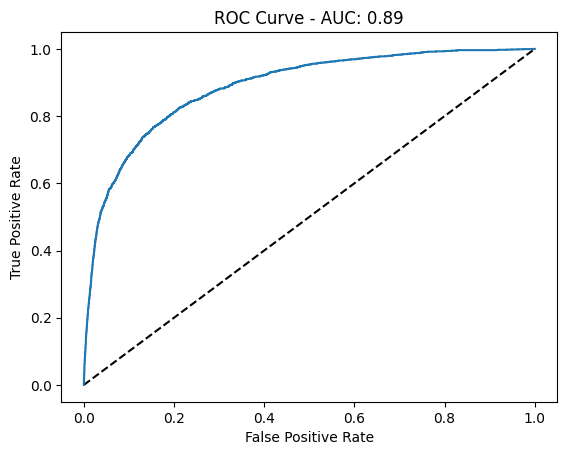

In [56]:
# Create the parameter grid based on the results of random search
param_grid = [
    {"solver": ["liblinear"], "penalty": ["l1"], "C": [1e-6], "max_iter": [int(1e6)]},
    {
        "solver": ["newton-cg", "lbfgs", "liblinear"],
        "penalty": ["l2"],
        "max_iter": [50, 100],
        "C": [0.01, 0.1, 1],
    },
]

# Create a base model
clf_logistic = LogisticRegression()

# Create a custom scoring function for precision
precision_scorer = make_scorer(precision_score)

# Instantiate the grid search model with precision as the scoring function
grid_search = GridSearchCV(
    estimator=clf_logistic,
    param_grid=param_grid,
    scoring=precision_scorer,
    cv=2,
    n_jobs=-1,
    verbose=5,
)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)

# Predict the test set using the best model
y_pred = grid_search.best_estimator_.predict(X_test)

# Evaluate the model
print ("Classification report:")
print(classification_report(y_test, y_pred))
print("Confusion matrix:")
display(pd.DataFrame(confusion_matrix(y_test, y_pred), index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

# ROC curve
y_pred_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve - AUC: {roc_auc_score(y_test, y_pred_prob):0.2f}")
plt.show()

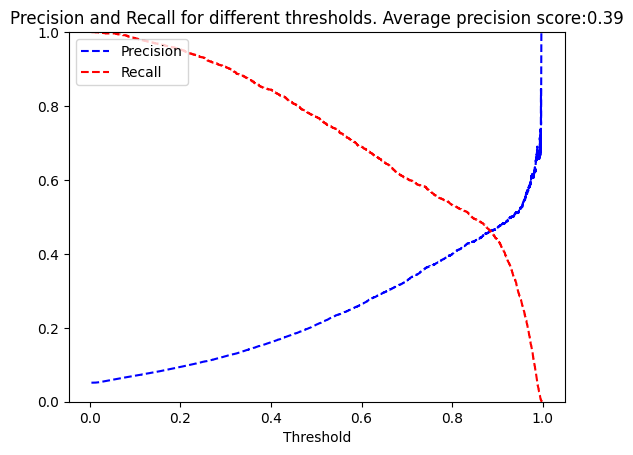

In [57]:
# Printing precision and recall for different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.plot(thresholds, precision[:-1], "b--", label="Precision")
plt.plot(thresholds, recall[:-1], "r--", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="upper left")
plt.title(f"Precision and Recall for different thresholds. Average precision score:{average_precision_score(y_test, y_pred_prob):0.2f}")
plt.ylim([0, 1])
plt.show()



Best estimator:LogisticRegression(C=1, solver='newton-cg')


Best parameters:{'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


Best score:0.828216875962234


Best index:16


Best average score:[0.         0.79222628 0.69259932 0.79100225 0.79193743 0.71352788
 0.79100225 0.82344648 0.6933776  0.82291479 0.8233746  0.71617962
 0.82291479 0.8275135  0.69346682 0.82743626 0.82821688 0.70908674
 0.82743626]


Best results:{'mean_fit_time': array([0.05547941, 0.94474387, 0.07642877, 0.33382022, 1.27872789,
       0.14548314, 0.32631922, 1.07474804, 0.08662581, 0.48447776,
       1.71894419, 0.1470747 , 0.48593557, 0.94986093, 0.09289813,
       0.4990586 , 1.23485947, 0.16549897, 0.3326447 ]), 'std_fit_time': array([0.03257239, 0.03125596, 0.00393975, 0.00337613, 0.23384416,
       0.00675976, 0.00814819, 0.28702521, 0.00861335, 0.0548501 ,
       0.09724057, 0.00071788, 0.08677256, 0.05210984, 0.01559734,
       0.14265716, 0.01612139, 0.00878859, 0.04874539]), 'mean_sc

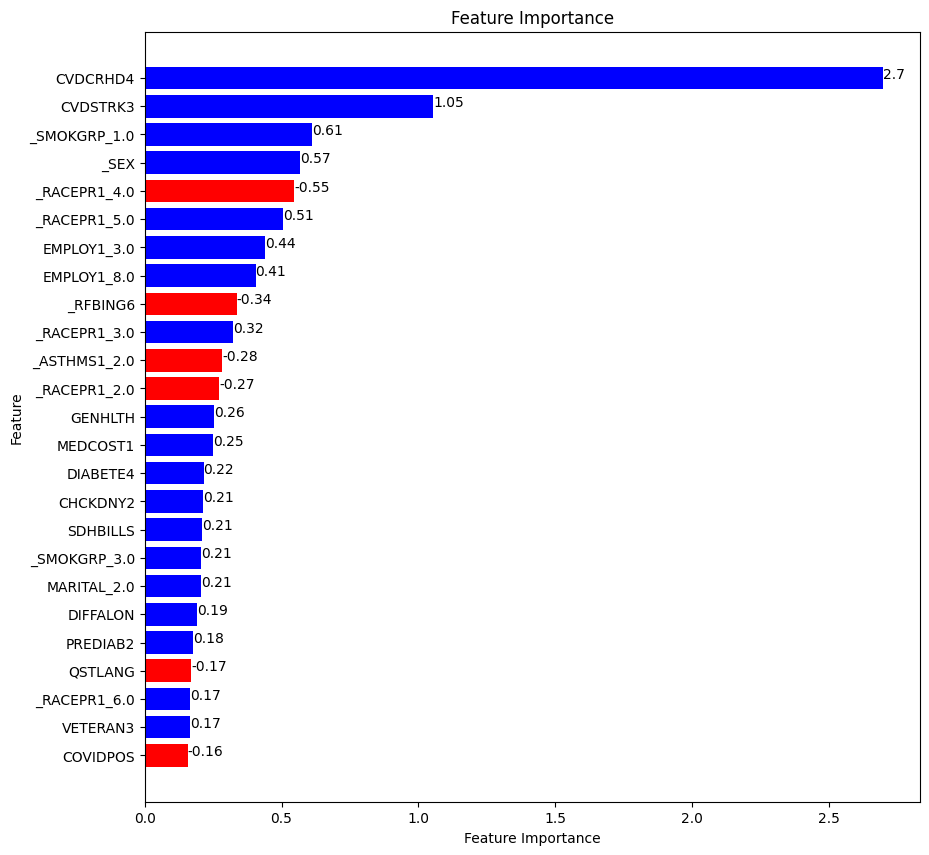

In [58]:
# Print the best model
print(f"\n\nBest estimator:{grid_search.best_estimator_}")

# Print the best parameters
print(f"\n\nBest parameters:{grid_search.best_params_}")

# Print the best score
print(f"\n\nBest score:{grid_search.best_score_}")

# Print the best index
print(f"\n\nBest index:{grid_search.best_index_}")

# Print average score
print(f"\n\nBest average score:{grid_search.cv_results_['mean_test_score']}")

# Print the results
print(f"\n\nBest results:{grid_search.cv_results_}")

# Count the number of features with negative coefficients
negative_coefficients = sum(grid_search.best_estimator_.coef_[0] < 0)
print(f"\n\nNumber of features with negative coefficients: {negative_coefficients}")

# Plot feature importance
feature_importance = dict(zip(X.columns, zip(np.abs(grid_search.best_estimator_.coef_[0]), np.where(grid_search.best_estimator_.coef_[0]>=0, 1, -1))))
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1][0], reverse=False)
print ("\n\nFeature importance:")
for feature in sorted_features:
    print(feature)

# Plot feature importance with feature importance values as data labels
plt.figure(figsize=(10, 10))
top_n = 25
colors = ["blue" if x[1][1]==1 else "red" for x in sorted_features[-top_n:]]
plt.barh(
    [x[0] for x in sorted_features[-top_n:]],
    [x[1][0] for x in sorted_features[-top_n:]],
    color=colors,
)
for index, value in enumerate([x[1] for x in sorted_features[-top_n:]]):
    plt.text(value[0], index, str(value[1]*round(value[0], 2)))
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()


In [59]:
# Save the model
joblib.dump(grid_search.best_estimator_, '../models/lr_model.pkl')

# Save the test set
# X_test.to_pickle('../data/logistic_regression_test_set.pkl')
# y_test.to_pickle('../data/logistic_regression_test_labels.pkl')

# Save the ROC curve
# roc_curve_data = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds})
# roc_curve_data.to_pickle('../data/logistic_regression_roc_curve.pkl')

# Save the classification report
# classification_report_data = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
# classification_report_data.to_pickle('../data/logistic_regression_classification_report.pkl')

# Save the confusion matrix
# confusion_matrix_data = pd.DataFrame(confusion_matrix(y_test, y_pred))

# confusion_matrix_data.to_pickle('../data/logistic_regression_confusion_matrix.pkl')

# Save the AUC
# auc_data = pd.DataFrame({'AUC': [roc_auc_score(y_test, y_pred_prob)]})
# auc_data.to_pickle('../data/logistic_regression_auc.pkl')

# Save the hyperparameters
# hyperparameters = pd.DataFrame({'C': [grid_search.best_params_['C']], 'penalty': [grid_search.best_params_['penalty']]})
# hyperparameters.to_pickle('../data/logistic_regression_hyperparameters.pkl')

# Save the feature importance coefficients and intercept
# Get feature names from grid_search.best_estimator_
model_coefficients=pd.DataFrame({'feature':X.columns, 'coefficient':grid_search.best_estimator_.coef_[0]})
model_intercept=pd.DataFrame({'feature':['intercept'], 'coefficient':grid_search.best_estimator_.intercept_})

# Join intercept to the model coefficients
model_coefficients=pd.concat([model_coefficients, model_intercept], ignore_index=True)

model_coefficients.to_pickle('../data/lr_model_coefficients_intercept.pkl')

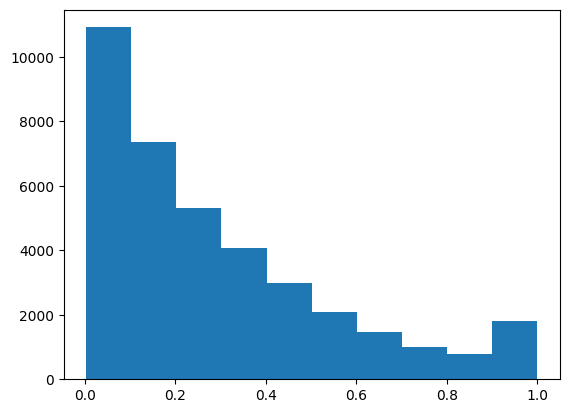

In [60]:
y_probs = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

# Create a histogram of the probabilities
plt.hist(y_probs, bins=10);

In [61]:
clf_lr=grid_search.best_estimator_

In [62]:
clf_lr.predict(X_test[2:3])

array([0.])

In [63]:
X_test_raw[2:3]

,GENHLTH,PHYSHLTH,MENTHLTH,PERSDOC3,MEDCOST1,CHECKUP1,SLEPTIM1,CVDCRHD4,CVDSTRK3,CHCOCNC1,CHCCOPD3,ADDEPEV3,CHCKDNY2,DIABETE4,EDUCA,VETERAN3,CHILDREN,INCOME3,DECIDE,DIFFALON,COVIDPOS,PREDIAB2,CNCRDIFF,LSATISFY,EMTSUPRT,SDHISOLT,SDHEMPLY,FOODSTMP,SDHFOOD1,SDHBILLS,SDHUTILS,SDHTRNSP,SDHSTRE1,QSTLANG,_METSTAT,_URBSTAT,_HLTHPLN,_TOTINDA,_DRDXAR2,_SEX,_AGE80,HTM4,WTKG3,_BMI5,_RFBING6,_DRNKWK2,_RFDRHV8,_ASTHMS1_2.0,_ASTHMS1_3.0,RENTHOM1_1.0,RENTHOM1_3.0,_BMI5CAT_1.0,_BMI5CAT_2.0,_BMI5CAT_3.0,_RACEPR1_2.0,_RACEPR1_3.0,_RACEPR1_4.0,_RACEPR1_5.0,_RACEPR1_6.0,_RACEPR1_7.0,_SMOKGRP_1.0,_SMOKGRP_3.0,EMPLOY1_3.0,EMPLOY1_5.0,EMPLOY1_7.0,EMPLOY1_8.0,MARITAL_2.0,MARITAL_5.0
14029,1.00,3.00,0.00,1,0.00,1.00,8.00,0.00,0.00,0.00,0.00,0.00,0.00,0,4.00,0.00,0.00,5.00,0.00,0.00,2.00,0,0.00,1,1.00,5.00,0.00,0.00,5.00,1.00,1.00,1.00,5.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00,23.00,157.00,5080.00,2048.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00


In [64]:
record=[1, 	3, 	0, 	1, 	0, 	1, 	8, 	0, 	0, 	0, 	0, 	0, 	0, 	0, 	4, 	0, 	0, 	5, 	0, 	0, 	2, 	0, 	0, 	1, 	1, 	5, 	0, 	0, 	5, 	1, 	1, 	1, 	5, 	1, 	0, 	1, 	1, 	0, 	0, 	0, 	23, 	157, 	5080, 	2048, 	0, 	0, 	0, 	0, 	1, 	0, 	0, 	0, 	1, 	0, 	0, 	0, 	0, 	0, 	0, 	0, 	0, 	0, 	0, 	0, 	0, 	0, 	0, 	1]

In [65]:
scaler.transform([record])

c:\Users\Anuvrat\OneDrive\Documents\siads\capstone\venv_capstone\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[-1.46149254, -0.13951679, -0.52485674,  0.36580801, -0.2821002 ,
        -0.41644571,  0.67333262, -0.25110896, -0.20537036, -0.37095149,
        -0.28655899, -0.52256428, -0.21646035, -0.42403804, -1.19131254,
        -0.38076617, -0.48288731, -0.87883946, -0.34578856, -0.26937353,
         0.68507998, -0.22819549, -0.21108675,  0.23062444, -0.82230801,
         0.94289876, -0.31238268, -0.30143734,  0.39013773,  3.38355359,
         4.26587185,  4.15563983,  0.9927639 ,  0.1379945 , -1.59296793,
         0.4050977 ,  0.21992184, -1.92300824, -0.72250666, -0.95503439,
        -1.86075928, -1.29258854, -1.53068187, -1.24005296, -0.41039531,
        -0.38693915, -0.27224483, -0.21376646,  0.41202286, -1.70381803,
        -0.2090523 , -0.12927304,  1.55933217, -0.7459054 , -0.26482392,
        -0.11639412, -0.14308655, -0.04277448, -0.13334052, -0.28920042,
        -0.31776297, -0.63953324, -0.18974764, -0.25330533, -0.69092582,
        -0.2371082 , -0.57509879,  2.25106366]])

In [66]:
clf_lr.predict(scaler.fit_transform([record]))

c:\Users\Anuvrat\OneDrive\Documents\siads\capstone\venv_capstone\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([0.])

#### Specific LR Models

Classification report:
              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91     35837
         1.0       0.21      0.77      0.33      1944

    accuracy                           0.84     37781
   macro avg       0.60      0.80      0.62     37781
weighted avg       0.95      0.84      0.88     37781

Confusion matrix:


,Predicted 0,Predicted 1
Actual 0,30220,5617
Actual 1,456,1488


Accuracy: 0.8392578280087875
Precision: 0.20942997888810697
Recall: 0.7654320987654321


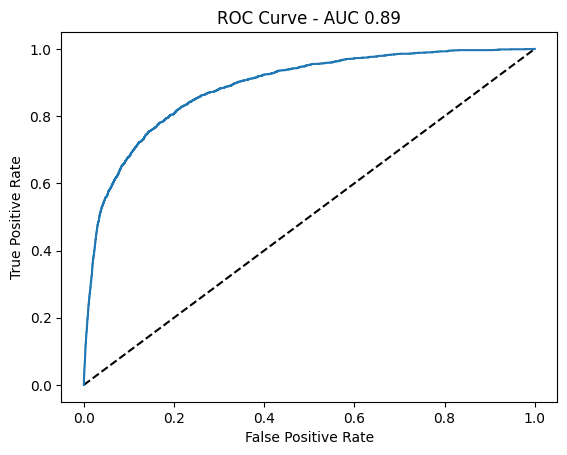

In [67]:
# Create an LR model
clf_logistic = LogisticRegression(solver= "liblinear", penalty= "l1", C= 0.1)

# Fit the grid search to the data
clf_logistic.fit(X_train, y_train)

# Predict the test set using the LR model
y_pred = clf_logistic.predict(X_test)

# Evaluate the model
print("Classification report:")
print(classification_report(y_test, y_pred))
print("Confusion matrix:")
display(pd.DataFrame(confusion_matrix(y_test, y_pred), index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

# ROC curve
y_pred_prob = clf_logistic.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve - AUC {roc_auc_score(y_test, y_pred_prob):0.2f}")
plt.show()

### Random Forest

Fitting 3 folds for each of 20 candidates, totalling 60 fits


{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': True}
RandomForestClassifier(max_depth=50, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200)
0.8077489648606438
0
[0.80774896 0.80628247 0.80567165 0.80677131 0.80542682 0.80701551
 0.80530463 0.80432671 0.80652649 0.80738217 0.80738217 0.80359376
 0.8050603  0.80579348 0.8046936  0.80444935 0.80677113 0.8034713
 0.8056712  0.80701542]
{'mean_fit_time': array([ 1.42221689,  5.86893757,  5.6845274 , 12.19113374,  9.49911157,
        4.4414831 , 19.74385341,  1.24772843,  7.50119694, 14.72172976,
        3.34546399,  9.57823277,  8.45070974, 12.46857858, 16.50158731,
        9.41700745,  7.98730699,  4.84815534, 15.52652001,  9.46349661]), 'std_fit_time': array([0.07673534, 0.10992712, 0.1420566 , 0.26137193, 0.13436577,
       0.0853561 , 0.17539068, 0.04781116, 0.04684802, 0.1243794 ,
       0.05909255, 0.14480574, 0.05281066, 0.13

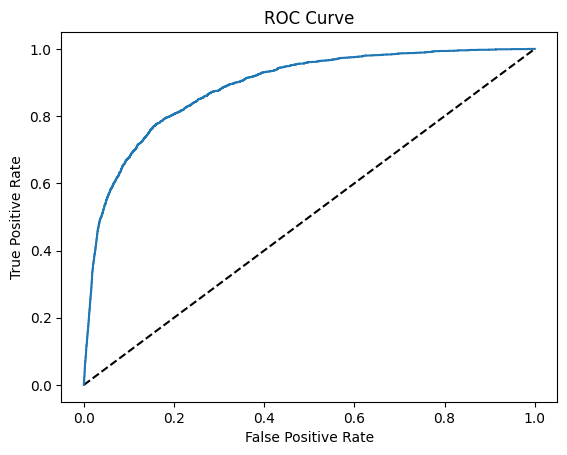

AUC: 0.8871314172732944


In [68]:
# Perform random search for hyperparameter tuning using random forest classifier
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
# Number of features to consider at every split
max_features = ["log2", "sqrt"]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
clf_random_forest = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
clf_random = RandomizedSearchCV(
    estimator=clf_random_forest,
    param_distributions=random_grid,
    n_iter=20,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)
# Fit the random search model
clf_random.fit(X_train, y_train)

# Print the best parameters
print(clf_random.best_params_)
# Print the best model
print(clf_random.best_estimator_)
# Print the best score
print(clf_random.best_score_)
# Print the best index
print(clf_random.best_index_)
# Print average score
print(clf_random.cv_results_["mean_test_score"])
# Print the results
print(clf_random.cv_results_)
# Print feature importance
feature_importance = dict(
    zip(X.columns, clf_random.best_estimator_.feature_importances_)
)
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
for feature in sorted_features:
    print(feature)

# Predict the test set using the best model
y_pred = clf_random.best_estimator_.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

# ROC curve
y_pred_prob = clf_random.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

# AUC
print("AUC:", roc_auc_score(y_test, y_pred_prob))

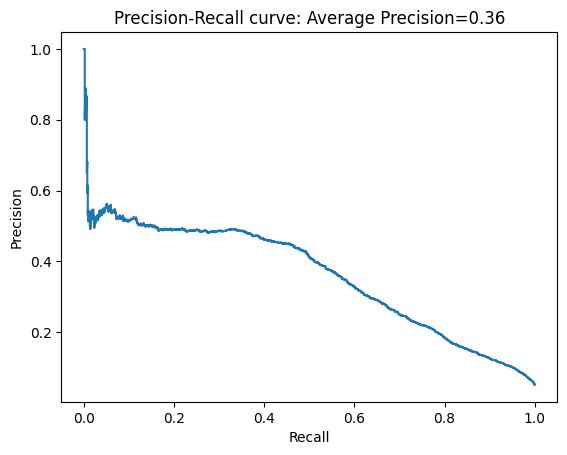

In [69]:
# Plot PR curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)
# Show the average precision in the plot

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(
    f"Precision-Recall curve: Average Precision={average_precision:0.2f}"
)
plt.show()

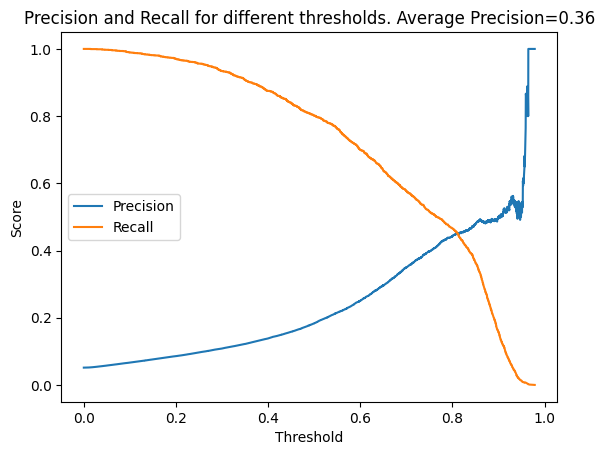

In [70]:
# Plot Precision and Recall for different thresholds
plt.plot(thresholds, precision[1:], label="Precision")
plt.plot(thresholds, recall[1:], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title(f"Precision and Recall for different thresholds. Average Precision={average_precision:0.2f}")
plt.show()

In [71]:
# Print precision and recall for different thresholds
threshold_values = np.linspace(0, 1, 11)
for threshold in threshold_values:
    if threshold > thresholds.max():
        threshold = thresholds.max()
    else:
        threshold=np.round(threshold, 2)
    precision_threshold = precision[np.where(thresholds >= threshold)[0][0]]
    recall_threshold = recall[np.where(thresholds >= threshold)[0][0]]
    print(
        f"Threshold: {threshold:0.2f}, Precision: {precision_threshold:0.2f}, Recall: {recall_threshold:0.2f}"
    )

Threshold: 0.00, Precision: 0.05, Recall: 1.00
Threshold: 0.10, Precision: 0.07, Recall: 0.99
Threshold: 0.20, Precision: 0.09, Recall: 0.97
Threshold: 0.30, Precision: 0.11, Recall: 0.93
Threshold: 0.40, Precision: 0.14, Recall: 0.88
Threshold: 0.50, Precision: 0.18, Recall: 0.80
Threshold: 0.60, Precision: 0.25, Recall: 0.70
Threshold: 0.70, Precision: 0.35, Recall: 0.58
Threshold: 0.80, Precision: 0.44, Recall: 0.47
Threshold: 0.90, Precision: 0.50, Recall: 0.16
Threshold: 0.98, Precision: 1.00, Recall: 0.00


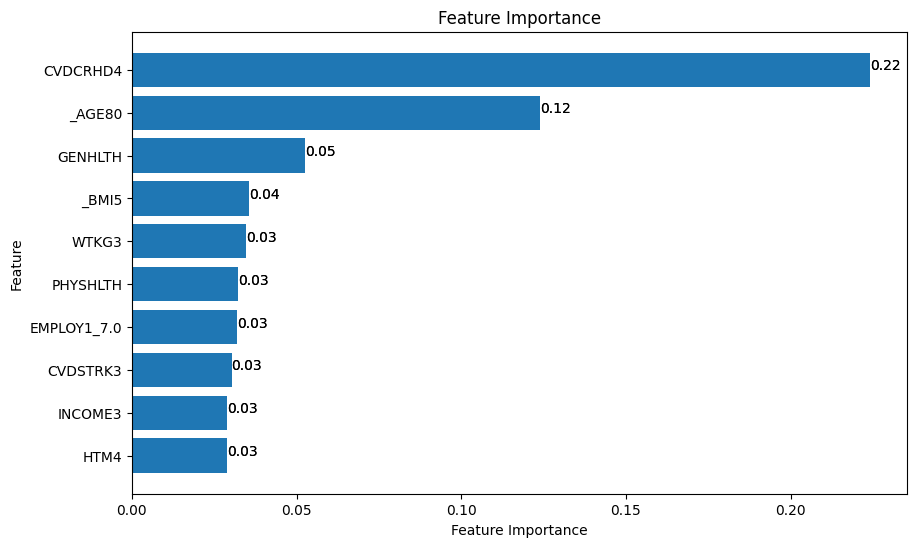

In [72]:
# Feature importance plot with feature importance values as data labels
sorted_features_reverse = sorted(feature_importance.items(), key=lambda x: x[1], reverse=False)
plt.figure(figsize=(10, 6))
plt.barh(
    [x[0] for x in sorted_features_reverse[-10:]],
    [x[1] for x in sorted_features_reverse[-10:]],
)

for index, value in enumerate([x[1] for x in sorted_features_reverse[-10:]]):
    plt.text(value, index, str(round(value, 2)))

# Add feature imporatance values ad data labels to the plot
for index, value in enumerate([x[1] for x in sorted_features_reverse[-10:]]):
    plt.text(value, index, str(round(value, 2)))



plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()

In [73]:
clf_random.cv_results_

{'mean_fit_time': array([ 1.42221689,  5.86893757,  5.6845274 , 12.19113374,  9.49911157,
         4.4414831 , 19.74385341,  1.24772843,  7.50119694, 14.72172976,
         3.34546399,  9.57823277,  8.45070974, 12.46857858, 16.50158731,
         9.41700745,  7.98730699,  4.84815534, 15.52652001,  9.46349661]),
 'std_fit_time': array([0.07673534, 0.10992712, 0.1420566 , 0.26137193, 0.13436577,
        0.0853561 , 0.17539068, 0.04781116, 0.04684802, 0.1243794 ,
        0.05909255, 0.14480574, 0.05281066, 0.13319183, 0.17528198,
        0.11589184, 0.09790237, 0.0755282 , 0.13481895, 0.03656279]),
 'mean_score_time': array([0.07890717, 0.28709817, 0.31957539, 0.6277473 , 0.57588712,
        0.18697429, 0.98067013, 0.06004055, 0.45387594, 0.95640453,
        0.18224271, 0.38815602, 0.45271937, 0.56202078, 0.7652816 ,
        0.5707132 , 0.40279738, 0.3237164 , 0.61875486, 0.49937399]),
 'std_score_time': array([0.00639127, 0.00603231, 0.0303744 , 0.00641671, 0.02604638,
        0.00541568, 

c:\Users\Anuvrat\OneDrive\Documents\siads\capstone\venv_capstone\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


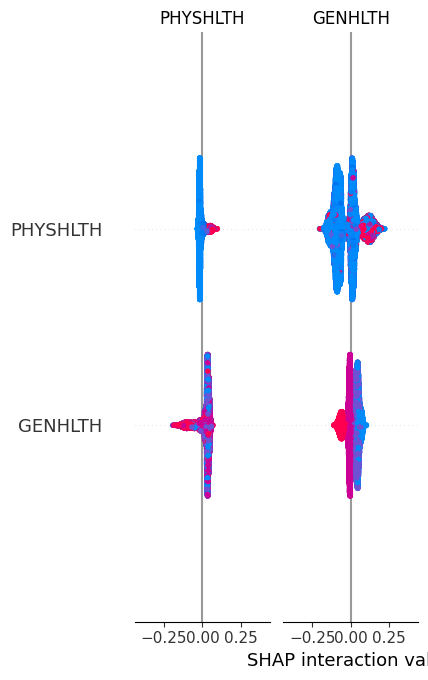

In [76]:
# Shapley analysis with values and plot
import shap
shap.initjs()
explainer = shap.TreeExplainer(clf_random.best_estimator_)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

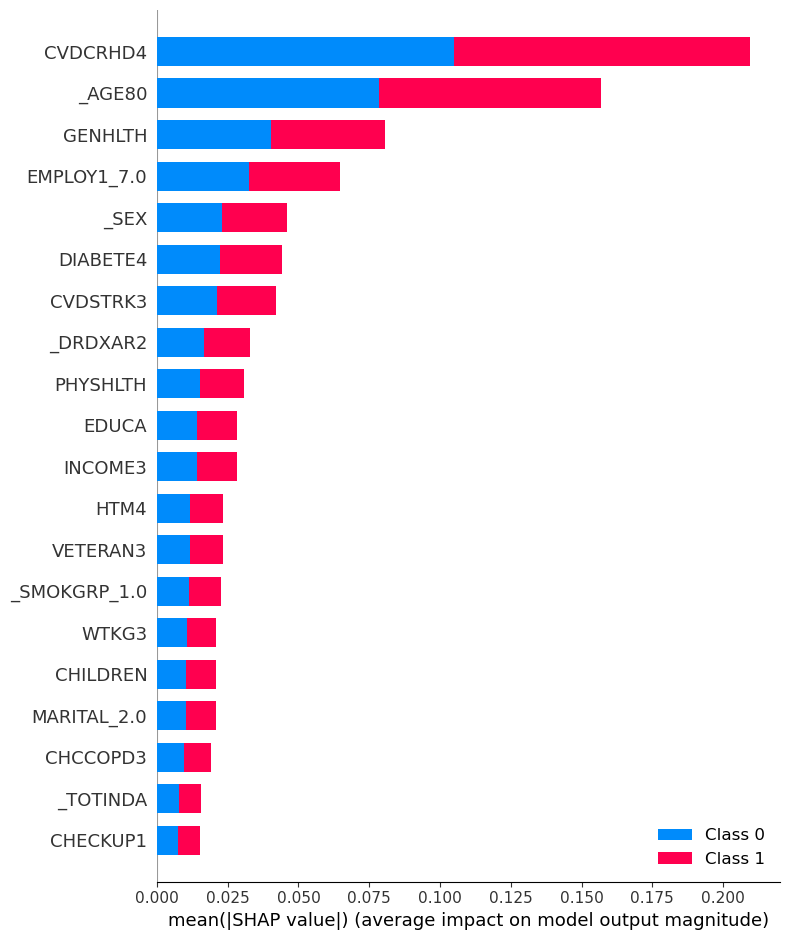

In [ ]:
# Shapley plot with feature names and values as data labels
shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="bar")


Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead


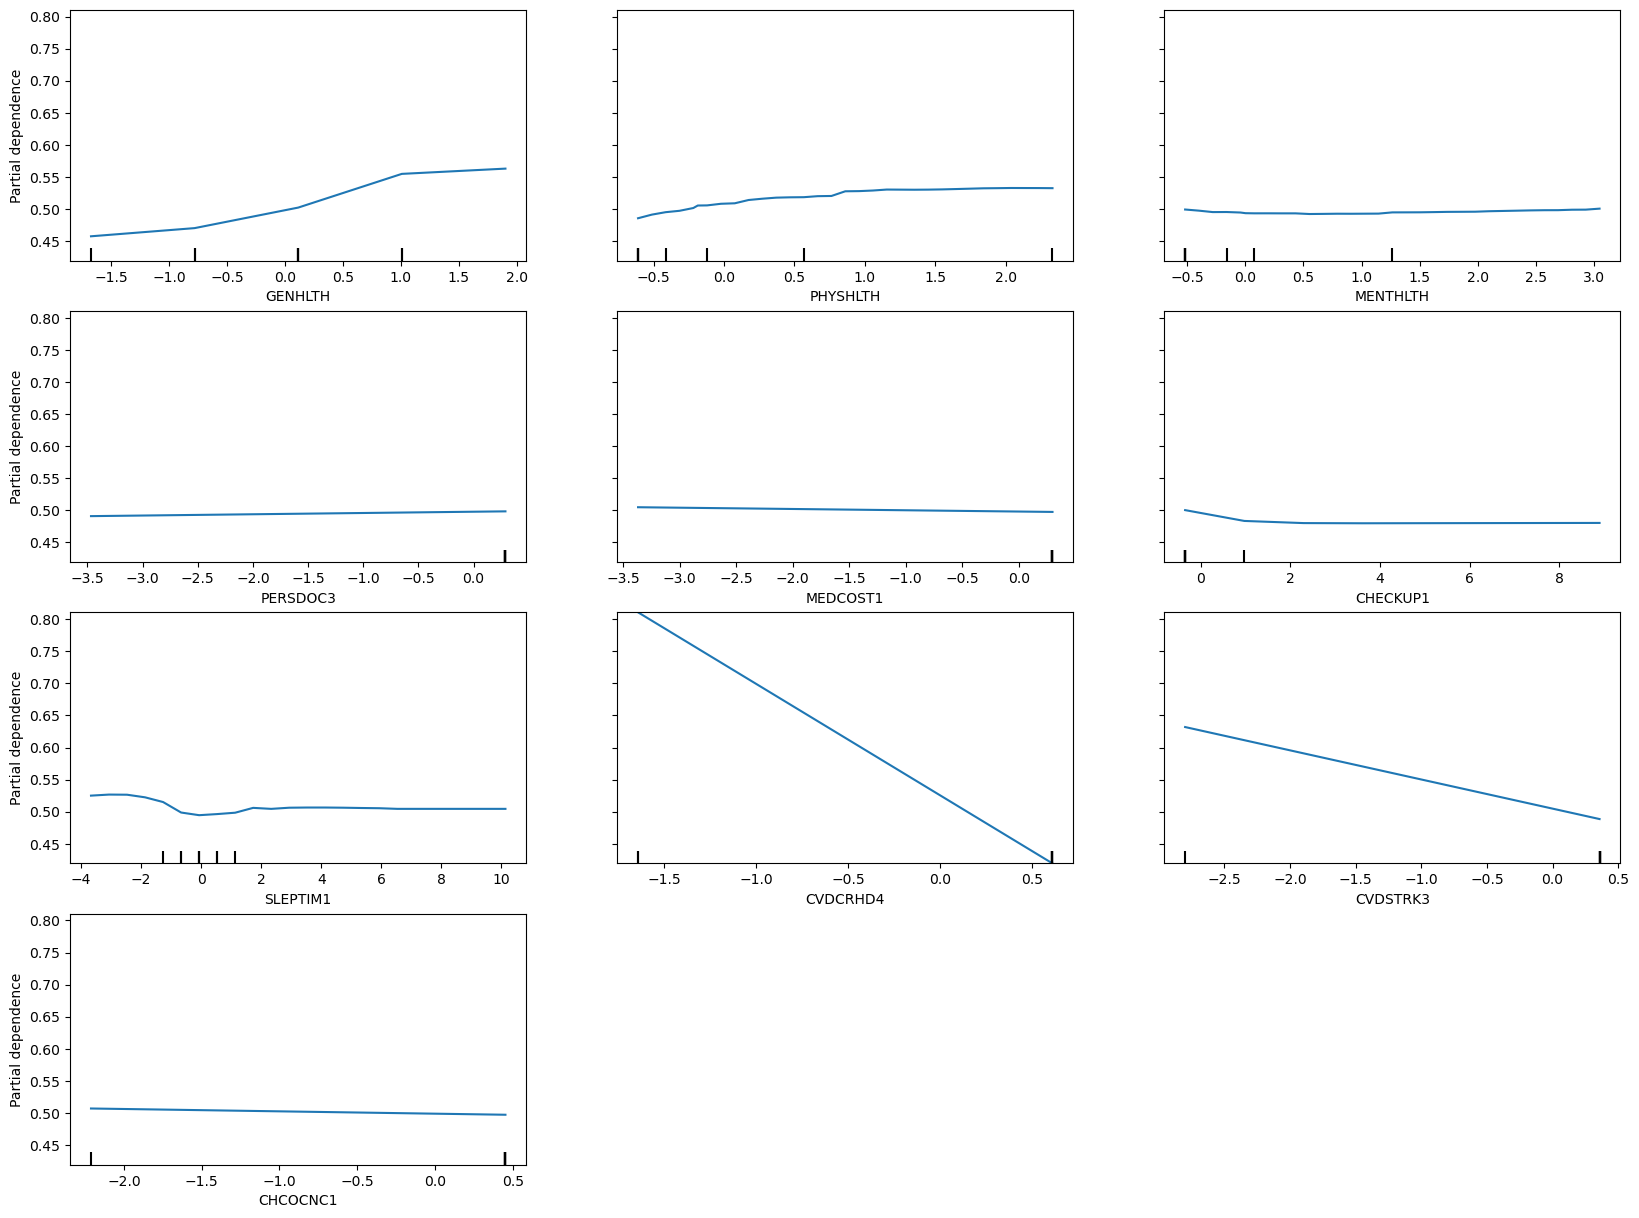

In [ ]:
# Partial dependence plot
from sklearn.inspection import plot_partial_dependence

# Set figure size
fig, ax = plt.subplots(1, 1, figsize=(20, 15))

# Plot partial dependence on figure
plot_partial_dependence(clf_random.best_estimator_, X_train, features=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], feature_names=X.columns, grid_resolution=50, ax=ax)
plt.show()

### XGBoost

#### Using Random Search

In [83]:
# Create an XGBClassifier using the best parameters from the random search
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=20, stop=2000, num=100)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 50, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_child_weight = [1, 2, 4]
# Minimum number of samples required at each leaf node
gamma = [0.1, 0.2, 0.3]
# Learning rate
learning_rate = [0.01, 0.1, 0.2]
# Create the parameter grid
param_grid_xgb = {
    "n_estimators": n_estimators,
    "max_depth": max_depth,
    "min_child_weight": min_child_weight,
    "gamma": gamma,
    "learning_rate": learning_rate,
}

# Create a base model
clf_xgb = XGBClassifier(reg_alpha=0.002, colsample_bytree=0.8)

# Create a custom scoring function for precision
precision_scorer = make_scorer(precision_score)

# Instantiate the random search model with precision as the scoring function
grid_search_xgb = RandomizedSearchCV(
    estimator=clf_xgb,
    param_distributions=param_grid_xgb,
    n_iter=20,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring=precision_scorer,
)

# Fit the grid search to the data
grid_search_xgb.fit(X_train, y_train)
print("Best parameters found: ", grid_search_xgb.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters found:  {'n_estimators': 480, 'min_child_weight': 1, 'max_depth': 1, 'learning_rate': 0.1, 'gamma': 0.2}


Classification report:
              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91     35837
         1.0       0.21      0.77      0.33      1944

    accuracy                           0.84     37781
   macro avg       0.60      0.81      0.62     37781
weighted avg       0.95      0.84      0.88     37781

Confusion matrix:


,Predicted 0,Predicted 1
Actual 0,30198,5639
Actual 1,446,1498


Accuracy: 0.8389402080410788
Precision: 0.2098921115314558
Recall: 0.7705761316872428


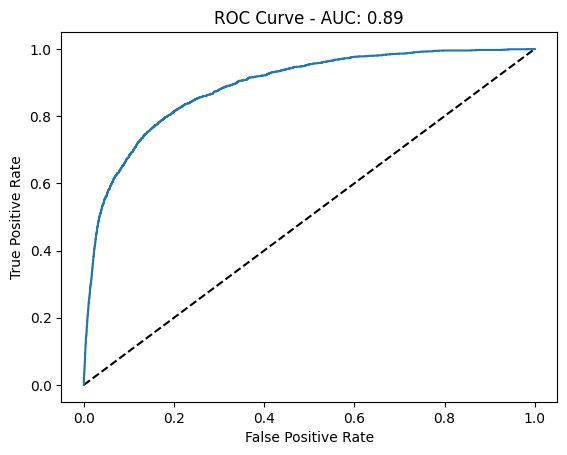

AUC: 0.8882843426529655


Best estimator:XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=480, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


Best parameters:{'n_estimators': 480, 'min_child_weight': 1, 'max_depth': 1, 'learning_rate': 0.1, 'gamma': 0.2}


Best score:0.8318923229256264


Best index:14


Best average score:[0.80303941 0.79954233 0.80

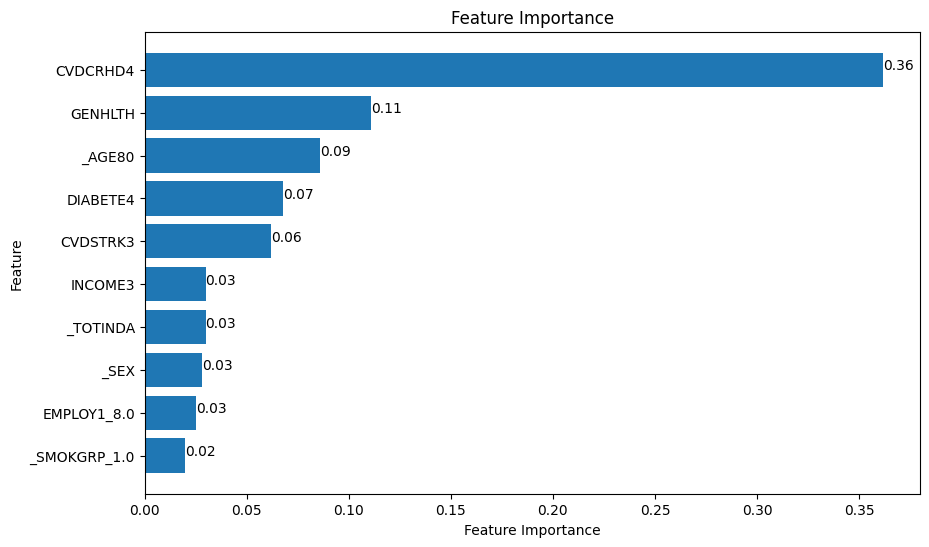

In [84]:
# Predict the test set using the best model
y_pred = grid_search_xgb.best_estimator_.predict(X_test)

# Evaluate the model
print("Classification report:")
print(classification_report(y_test, y_pred))
print("Confusion matrix:")
display(pd.DataFrame(confusion_matrix(y_test, y_pred), index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

# ROC curve
y_pred_prob = grid_search_xgb.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve - AUC: {roc_auc_score(y_test, y_pred_prob):0.2f}")
plt.show()

# AUC
print("AUC:", roc_auc_score(y_test, y_pred_prob))

# Print the best model
print(f"\n\nBest estimator:{grid_search_xgb.best_estimator_}")

# Print the best parameters
print(f"\n\nBest parameters:{grid_search_xgb.best_params_}")

# Print the best score
print(f"\n\nBest score:{grid_search_xgb.best_score_}")

# Print the best index
print(f"\n\nBest index:{grid_search_xgb.best_index_}")

# Print average score
print(f"\n\nBest average score:{grid_search_xgb.cv_results_['mean_test_score']}")
# Print the results
print(f"\n\nBest results:{grid_search_xgb.cv_results_}")

# Plot Feature Importance
feature_importance = dict(
    zip(X.columns, grid_search_xgb.best_estimator_.feature_importances_)
)

# Plot feature importance with feature importance values as data labels
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=False)
plt.figure(figsize=(10, 6))
plt.barh(
    [x[0] for x in sorted_features[-10:]],
    [x[1] for x in sorted_features[-10:]],
)
for index, value in enumerate([x[1] for x in sorted_features[-10:]]):
    plt.text(value, index, str(round(value, 2)))
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()

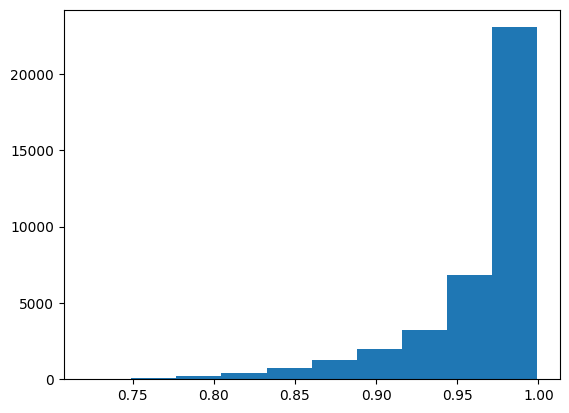

In [ ]:
y_probs = grid_search_xgb.predict_proba(X_test)[:, 1]

# Create a histogram of the probabilities
plt.hist(y_probs, bins=10);

In [ ]:
# Shapley analysis with values and plot
import shap
shap.initjs()
explainer = shap.TreeExplainer(grid_search_xgb.best_estimator_)
shap_values_xgb = explainer.shap_values(X_test)
shap.summary_plot(shap_values_xgb, X_test, plot_type="bar")

### LGBM

In [ ]:
# Create a LGBM model
clf_lgb = lgb.LGBMClassifier(
    boosting_type="gbdt",
    objective="binary",
    metric="binary_logloss",
    n_estimators=1000,
    reg_alpha=0.002,
    min_child_weight=1,
    max_depth=3,
    learning_rate=0.1,
    gamma=0.1,
    colsample_bytree=0.8,
)

# Fit the grid search to the data
clf_lgb.fit(X_train, y_train)

# Predict the test set using the LGBM model
y_pred = clf_lgb.predict(X_test)

# Evaluate the model
print("Classification report:")
print(classification_report(y_test, y_pred))
print("Confusion matrix:")
display(pd.DataFrame(confusion_matrix(y_test, y_pred), index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Info] Number of positive: 4076, number of negative: 4106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 950
[LightGBM] [Info] Number of data points in the train set: 8182, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498167 -> initscore=-0.007333
[LightGBM] [Info] Start training from score -0.007333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

,Predicted 0,Predicted 1
Actual 0,26023,9814
Actual 1,331,1613


Accuracy: 0.7314787856329902
Precision: 0.1411569090749978
Recall: 0.8297325102880658


In [ ]:
# Create an LGBMClassifier using the best parameters from the random search
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=20, stop=2000, num=100)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 50, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_child_weight = [1, 2, 4]
# Minimum number of samples required at each leaf node
gamma = [0.1, 0.2, 0.3]
# Learning rate
learning_rate = [0.01, 0.1, 0.2]
# Create the parameter grid
param_grid_lgb = {
    "n_estimators": n_estimators,
    "max_depth": max_depth,
    "min_child_weight": min_child_weight,
    "gamma": gamma,
    "learning_rate": learning_rate,
}

# Create a base model
clf_lgb = lgb.LGBMClassifier(objective="binary", reg_alpha=0.002)

# Create a custom scoring function for precision
precision_scorer = make_scorer(precision_score)

# Instantiate the random search model with precision as the scoring function
grid_search_lgb = RandomizedSearchCV(
    estimator=clf_lgb,
    param_distributions=param_grid_lgb,
    n_iter=20,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring=precision_scorer,
)

# Fit the grid search to the data
grid_search_lgb.fit(X_train, y_train)
print("Best parameters found: ", grid_search_lgb.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Info] Number of positive: 4076, number of negative: 4106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 950
[LightGBM] [Info] Number of data points in the train set: 8182, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498167 -> initscore=-0.007333
[LightGBM] [Info] Start training from score -0.007333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[LightGBM] [Warning] Unknown parameter: gamma
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.76      0.86     35837
           1       0.16      0.84      0.27      1944

    accuracy                           0.77     37781
   macro avg       0.57      0.80      0.56     37781
weighted avg       0.95      0.77      0.83     37781

Confusion matrix:


,Predicted 0,Predicted 1
Actual 0,27283,8554
Actual 1,316,1628


Accuracy: 0.7652259072020328
Precision: 0.15989000196425063
Recall: 0.8374485596707819
[LightGBM] [Warning] Unknown parameter: gamma


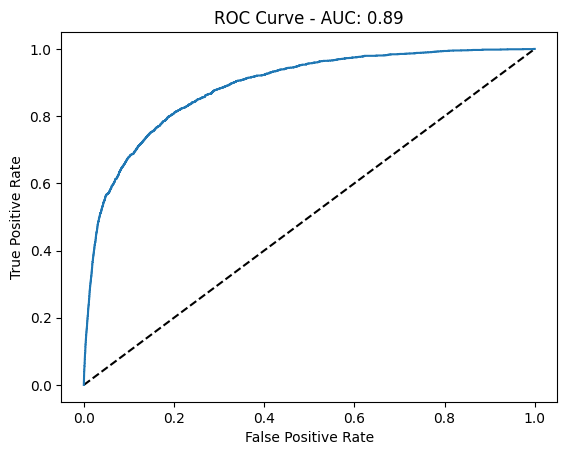

AUC: 0.8873399015386425


Best estimator:LGBMClassifier(gamma=0.2, max_depth=1, min_child_weight=1, n_estimators=480,
               objective='binary', reg_alpha=0.002)


Best parameters:{'n_estimators': 480, 'min_child_weight': 1, 'max_depth': 1, 'learning_rate': 0.1, 'gamma': 0.2}


Best score:0.8149117223893695


Best index:14


Best average score:[0.79445279 0.7814722  0.79411993 0.77956069 0.79045946 0.7809995
 0.79498775 0.79888612 0.80859507 0.78033795 0.7876919  0.78933811
 0.78722948 0.80160946 0.81491172 0.79218359 0.80111387 0.7819623
 0.78834163 0.78843874]


Best results:{'mean_fit_time': array([ 9.29718224, 14.1005818 , 10.57350222, 15.80598823,  0.64024345,
       10.15124035, 13.01466441,  8.42055798,  1.84288669, 10.7242229 ,
       10.58716893,  1.9892091 ,  6.19670415,  7.51280705,  0.50053557,
        3.86577535,  6.1679798 , 10.6164608 ,  4.61139377,  3.4071068 ]), 'std_fit_time': array([1.06528971, 1.03167143, 1.35432951, 0.76124927, 0.0725622 ,
       0.57103058

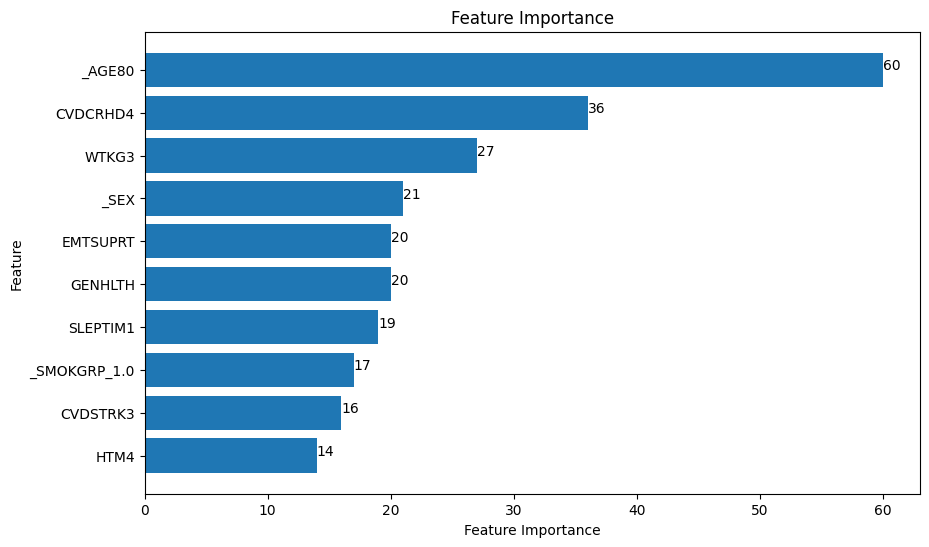

In [ ]:
# Predict the test set using the best model
y_pred = grid_search_lgb.best_estimator_.predict(X_test)

# Evaluate the model
print("Classification report:")
print(classification_report(y_test, y_pred))
print("Confusion matrix:")
display(pd.DataFrame(confusion_matrix(y_test, y_pred), index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

# ROC curve
y_pred_prob = grid_search_lgb.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve - AUC: {roc_auc_score(y_test, y_pred_prob):0.2f}")
plt.show()

# AUC
print("AUC:", roc_auc_score(y_test, y_pred_prob))

# Print the best model
print(f"\n\nBest estimator:{grid_search_lgb.best_estimator_}")

# Print the best parameters
print(f"\n\nBest parameters:{grid_search_lgb.best_params_}")

# Print the best score
print(f"\n\nBest score:{grid_search_lgb.best_score_}")

# Print the best index
print(f"\n\nBest index:{grid_search_lgb.best_index_}")

# Print average score
print(f"\n\nBest average score:{grid_search_lgb.cv_results_['mean_test_score']}")
# Print the results
print(f"\n\nBest results:{grid_search_lgb.cv_results_}")

# Plot Feature Importance
feature_importance = dict(
    zip(X.columns, grid_search_lgb.best_estimator_.feature_importances_)
)

# Plot feature importance with feature importance values as data labels
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=False)
plt.figure(figsize=(10, 6))
plt.barh(
    [x[0] for x in sorted_features[-10:]],
    [x[1] for x in sorted_features[-10:]],
)
for index, value in enumerate([x[1] for x in sorted_features[-10:]]):
    plt.text(value, index, str(round(value, 2)))
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()

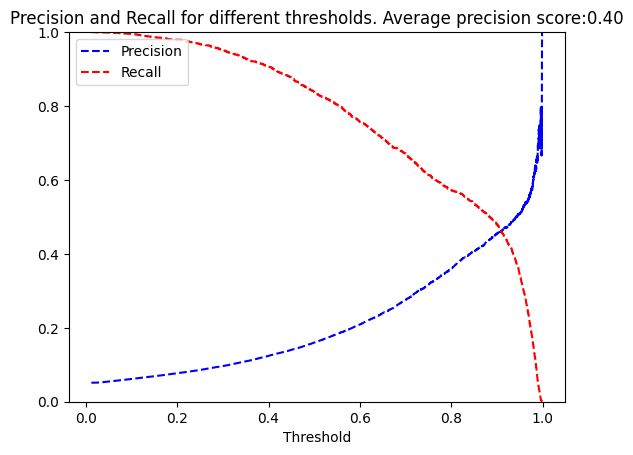

In [ ]:
# Precision and Recall for different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.plot(thresholds, precision[:-1], "b--", label="Precision")
plt.plot(thresholds, recall[:-1], "r--", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="upper left")
plt.title(f"Precision and Recall for different thresholds. Average precision score:{average_precision_score(y_test, y_pred_prob):0.2f}")
plt.ylim([0, 1])
plt.show()

## Comparison of results from various models

In [87]:
clf_lr = LogisticRegression(C=1.0, max_iter= 100, penalty="l2", solver="newton-cg")
clf_rf = RandomForestClassifier(n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features="sqrt", max_depth=5, bootstrap=True)
clf_xgb = XGBClassifier(reg_alpha=0.002, n_estimators=480, min_child_weight=1, max_depth=2, learning_rate=0.1, gamma=0.2, colsample_bytree=0.8)
clf_lgb= lgb.LGBMClassifier(boosting_type="gbdt", objective="binary", reg_alpha=0.002, n_estimators=1000, min_child_weight=1, max_depth=3, 
                            learning_rate=0.1, gamma=0.1, colsample_bytree=0.8)


for clf in [clf_lr, clf_rf, clf_xgb, clf_lgb]:
    print (f"\n\nModel: {clf}")
    # Fit the grid search to the data
    clf.fit(X_train, y_train)

    # Predict the test set using the XGB model
    y_pred = clf.predict(X_test)

    # Evaluate the model
    print("Confusion matrix:")
    display(pd.DataFrame(confusion_matrix(y_test, y_pred), index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))



Model: LogisticRegression(solver='newton-cg')
Confusion matrix:


,Predicted 0,Predicted 1
Actual 0,30140,5697
Actual 1,446,1498


Accuracy: 0.8374050448638204
Precision: 0.20820013898540654
Recall: 0.7705761316872428


Model: RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200)
Confusion matrix:


,Predicted 0,Predicted 1
Actual 0,29214,6623
Actual 1,409,1535


Accuracy: 0.8138746989227389
Precision: 0.18815886246629077
Recall: 0.7896090534979424


Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=480, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Confusion matrix:


,Predicted 0,Predicted 1
Actual 0,29648,6189
Actual 1,429,1515


Accuracy: 0.824832587808687
Precision: 0.19665109034267914
Recall: 0.779320987654321


Model: LGBMClassifier(colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=1,
               n_estimators=1000, objective='binary', reg_alpha=0.002)
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Info] Number of positive: 4076, number of negative: 4106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 887
[LightGBM] [Info] Number of data points in the train set: 8182, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498167 -> initscore=-0.007333
[LightGBM] [Info] Start training from score -0.007333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

,Predicted 0,Predicted 1
Actual 0,29044,6793
Actual 1,434,1510


Accuracy: 0.8087133744474736
Precision: 0.1818619775984584
Recall: 0.7767489711934157


## Save Models

In [ ]:
# Save the model
joblib.dump(clf_random.best_estimator_, '../models/rf_model.pkl')

['../models/rf_model.pkl']

In [125]:
data['_ASTHMS1_3.0'].value_counts()

_ASTHMS1_3.0
1.00    160994
0.00     27911
Name: count, dtype: int64

In [ ]:
Convert COVIDPOS

In [ ]:

from pathlib import Path
import base64


# Function to convert image to base64
@st.cache_resource
def get_base64_image(image_file):
    image_path = Path(image_file).resolve()
    with open(image_path, "rb") as f:
        return f"data:image/webp;base64,{base64.b64encode(f.read()).decode()}"


background_image = get_base64_image(".streamlit/backgroundimage2.webp")

# Set the background image with transparency
st.markdown(
    f"""
    <style>
    .stApp {{
        background: linear-gradient(rgba(255, 255, 255, 0.92), rgba(255, 255, 255, 0.92)), 
                    url("{background_image}");
        background-size: cover;
        background-repeat: no-repeat;
        background-attachment: fixed;
    }}
    </style>
    """,
    unsafe_allow_html=True,
)

In [ ]:

background_image_url = "https://github.com/anuvrat-umich/siads_capstone/blob/anuvrat/.streamlit/backgroundimage2.webp"

st.markdown(
    f"""
    <style>
    .stApp {{
        background: linear-gradient(rgba(255, 255, 255, 0.92), rgba(255, 255, 255, 0.92)), 
                    url("{background_image_url}");
        background-size: cover;
        background-repeat: no-repeat;
        background-attachment: fixed;
    }}
    </style>
    """,
    unsafe_allow_html=True,
)